# Decision Trees, Bias vs Variance, and Cross Validation

## Goals


- **Decision Trees** algorithm: how it works, how to use it, and how to interpret it.
    - Parameters
    - Visualizing decision trees
    - Validation and learning curves
- **Bias vs Variance** aka the eternal data science dilemma. We'll learn to find the right balance between the two.
- **Cross validation**. Testing how well our model does on data it hasn't seen before. 

In [24]:
!pip install graphviz

In [25]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix
from sklearn.tree import export_graphviz
from sklearn.model_selection import validation_curve, learning_curve
import graphviz

## Decision Trees

- One of the most popular and oldest machine learning models.
- Both a classification and regression supervised model.
- Intuitive. Very obvious why it's called "Decision Trees." 
- Foundation is asking a series of questions designed to zero-in on the classification. Sound familiar? (Hint: 20 questions.)
- Gateway model to more complex models such as Random Forests and Gradient Boosting.

### How a Decision Tree works
What makes Decision Trees great is that you can see the process in how it determines a classification.
<br><br>
Below is a decision tree that models data from the 2008 Democratic primary. It is predicting whether or not a county voted for Hillary Clinton or Barack Obama based on demographics and other features.

![Stuff](https://static01.nyt.com/images/2008/04/16/us/0416-nat-subOBAMA.jpg)

**Important:**

- What are the observations? How many observations are there?
- What is the response variable?
- What are the features?
- How are the predictions made?
- What is the most predictive feature?

The first split is "County > 20% Black Population". In this example, when a splitting rule is <b>True</b>, the model follows the right branch and when the splitting rule is <b>False</b>, it follows the left branch. 

#### Which candidate would the model predict winning this county?
15% Black, 82% HS graduation rate, located in Michigan, 60% earned less than $30,000
<br><br>
Whats the probability for this prediction?

- Number of questions indicates the depth of the model, which measures the complexitiy of a model. 
- Model splits until every observation that satisfies a series of conditions is of the same class or until the model reaches the maximum depth.
- Setting a maximum depth is known as "pruning" and not setting one or choosing too big of one can lead to overfitting.

<b> Why did this model make those decisions? Why is fewer than 20% black the first decision? Why 20% instead of 16 or 25?</b>
- At each node, we choose the decision that provides the best split, this is known as maximixing the information gain.
- The point where the split is made is determined by which point yields the lowest gini coefficient which measures the quality of a split (0 means perfect split.)
- Order of decisions is based on feature importance. The first decision is made on the model's most important feature. Very valuable method for feature selection and engineering.

### DT with Sklearn

In [26]:
#We're going to use sklearn to make some fake data.

#Generate fake data that is 400 x 2.
data = make_classification(n_samples=400, n_features=2, n_informative=2, n_redundant=0, 
                    class_sep=.74, random_state = 28)

In [27]:
# data[0] is the features
# data[1] is the labels

In [28]:
#Convert to pandas data frame
df = pd.DataFrame(data[0], columns=["feature1", "feature2"])
#Add target variable to df 
df["target"] = data[1]

df.head()

,feature1,feature2,target
0,0.479988,-0.904875,1
1,-0.251106,2.794837,0
2,-1.269605,-1.133941,0
3,0.834495,-0.684187,1
4,1.234570,-0.308881,1


Let's plot data with its color-encoded labels. Try to imagine how a decision tree would classify this data. Remember decision trees boundaries are vertical or horizontal.

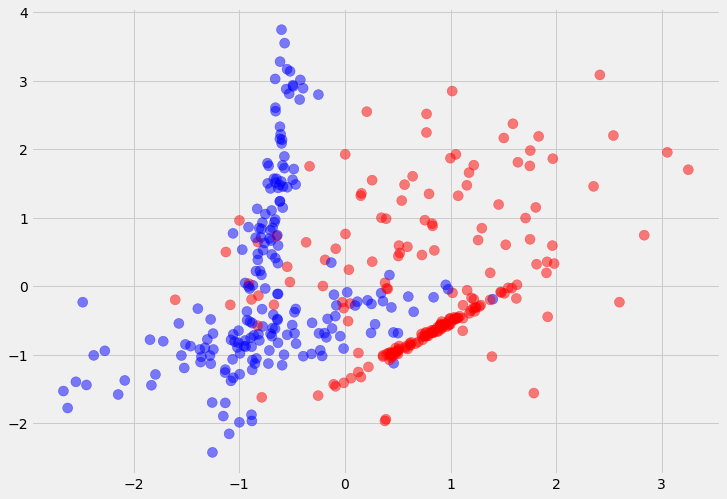

In [29]:
#Call scatter plot of feature1 vs feature2 with color-encoded target variable
plt.style.use("fivethirtyeight")
plt.figure(figsize=(11, 8))
#Color encode target variable
colors = df.target.map({0:"b", 1:"r"})
plt.scatter(df.feature1, df.feature2, c = colors, s = 100, alpha=.5);

Start thinking about how a model would classify red vs blue.

Time to see what the model says.
<br><br>
We are going to use the data to <b>train</b> or <b>fit</b> the model.

In [30]:
#Assign features to variable X
X = df.drop("target", axis = 1)
#Assign target column to variable y
y = df.target

#Fit a Decision Tree model with 2 depth on the data.

#1. Intialize the model, set max_depth = 2
model = DecisionTreeClassifier(max_depth=2)
#2. Fit/train the model. 
model.fit(X, y)

#The model specifications 

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [31]:
#Call predict on model and pass new data

point = [[0,0]]
model.predict(point)

array([1])

Probabilities of each class.

In [32]:
#Call predict_proba()
model.predict_proba(point)

array([[ 0.35294118,  0.64705882]])

Check how good our model by scoring the predictions

In [33]:
#Call .score() on model object and pass in the features and labels
model.score(X, y)

0.89249999999999996

Now we're going to use a plotting function to visualize the model.

What do you think that means?

In [34]:
#Retrain model but this time with depth 3
model = DecisionTreeClassifier(max_depth=3)
model.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [35]:
#Load in the model decision boundary function
def plot_decision_boundary(model, X, y):
    X_max = X.max(axis=0)
    X_min = X.min(axis=0)
    xticks = np.linspace(X_min[0], X_max[0], 100)
    yticks = np.linspace(X_min[1], X_max[1], 100)
    xx, yy = np.meshgrid(xticks, yticks)
    ZZ = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = ZZ >= 0.5
    Z = Z.reshape(xx.shape)
    plt.rcParams["figure.figsize"] = (10,7)
    fig, ax = plt.subplots()
    ax = plt.gca()
    ax.contourf(xx, yy, Z, cmap=plt.cm.bwr, alpha=0.2)
    ax.scatter(X[:,0], X[:,1], c=y, alpha=0.4, s = 50)

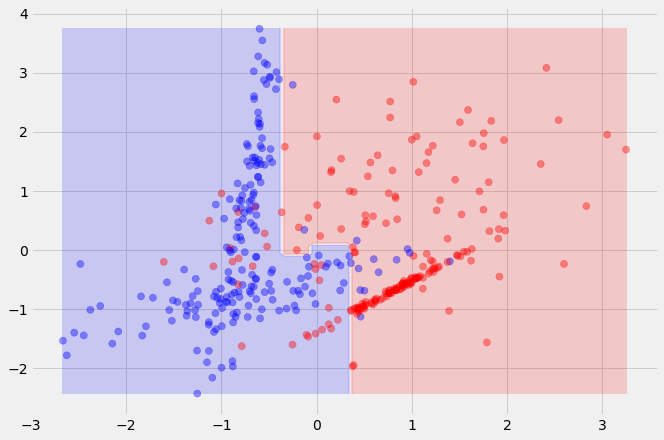

In [36]:
#Pass in model and data into function.
#Input a pretrained model, then features, then color-encoded target variables
plot_decision_boundary(model, X.values, colors);

Voila! These are the decision boundaries of decision tree model.

More examples of decision tree boundaries.

<br><br>

Four blobs

![Example1](https://image.ibb.co/m9EjYG/decisionblobs.png)



Credit: [Jake VanderPlas](https://jakevdp.github.io/PythonDataScienceHandbook/)

Observe how different decision tree models with varying depth values interpret the data.

![Blobs](https://image.ibb.co/hRE7nb/decisionblobboundaries.png)
Credit: Jake VanderPlas

### Iris dataset/tree visualization

We're going to train a decision tree model on the iris dataset and then use visualize the actual decision tree.

In [37]:
#Load in the iris dataset from seaborn
iris = sns.load_dataset("iris")

#Look at first five rows
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [38]:
#Data size
iris.shape

(150, 5)

In [39]:
#What are the classes of the target variable?
iris.species.unique()

array(['setosa', 'versicolor', 'virginica'], dtype=object)

#### Time for some quick EDA.

In [40]:
#Group the data by species and derive the average values of each attribute in each category
iris.groupby("species").mean()

,sepal_length,sepal_width,petal_length,petal_width
species,,,,
setosa,5.006,3.428,1.462,0.246
versicolor,5.936,2.770,4.260,1.326
virginica,6.588,2.974,5.552,2.026


What does this tell us about the differences and similarities of each species?

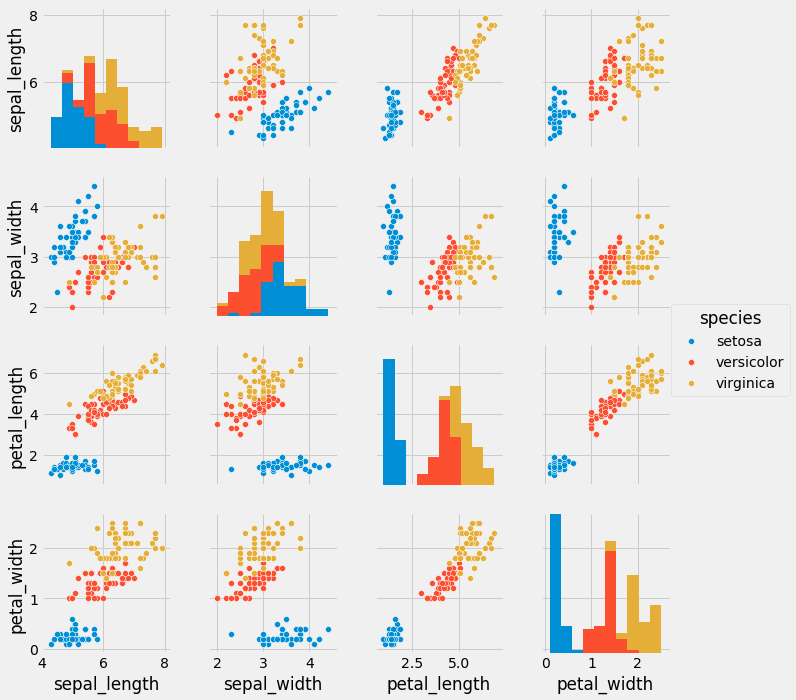

In [41]:
#Use a pairplot to visualize the dataset and use the species column to color encode the plots
sns.pairplot(iris, hue="species");

Again what does this tell us? How can we use this plot to our advantage when we create our machine learning model? What are the vertical and horizontal boundaries between the classes?

### Modeling time

In [42]:
#Assign iris features to X and species to y

X = iris.drop("species", axis=1)
y = iris.species

In [43]:
#Fit decision tree model on iris data with max depth set to 3

iris_model = DecisionTreeClassifier(max_depth=3)
iris_model.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [21]:
#Score the model.
iris_model.score(X, y)

0.97333333333333338

In [22]:
#Export the decision tree graph viz object. We have to export and the re-import it
export_graphviz(iris_model, out_file='iris.dot', 
                    feature_names=X.columns, 
                    class_names=y.unique())
with open("iris.dot") as f: 
        dot_graph = f.read()
graphviz.Source(dot_graph)

ExecutableNotFound: failed to execute ['dot', '-Tsvg'], make sure the Graphviz executables are on your systems' PATH

### Decision Tree Parameters

We've learned about max_depth, now let's look at some of the other parameters we can tune to improve our model.

Source: [Data Aspirant](http://dataaspirant.com/2017/02/01/decision-tree-algorithm-python-with-scikit-learn/)

**criterion:** It defines the function to measure the quality of a split. Sklearn supports “gini” criteria for Gini Index & “entropy” for Information Gain. By default, it takes “gini” value. (Further explanation on gini at the end of this notebook)

**max_features:** It defines the no. of features to consider when looking for the best split. We can input integer, float, string & None value.
    - If an integer is inputted then it considers that value as max features at each split.
    - If float value is taken then it shows the percentage of features at each split.
    
**max_depth:** The max_depth parameter denotes maximum depth of the tree. It can take any integer value or None. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples. By default, it takes “None” value.

**min_samples_split:** This tells above the minimum no. of samples reqd. to split an internal node. If an integer value is taken then consider min_samples_split as the minimum no. If float, then it shows percentage. By default, it takes “2” value.

**min_samples_leaf:** The minimum number of samples required to be at a leaf node. If an integer value is taken then consider min_samples_leaf as the minimum no. If float, then it shows percentage. By default, it takes “1” value.

**max_leaf_nodes:** It defines the maximum number of possible leaf nodes. If None then it takes an unlimited number of leaf nodes. By default, it takes “None” value.

**min_impurity_split:** It defines the threshold for early stopping tree growth. A node will split if its impurity is above the threshold otherwise it is a leaf.

## Bias vs Variance
<br><br>
<b>Bias:</b> The simplifying assumptions made by the model to make the target function easier to approximate.

<b>Variance:</b> The amount that the estimate of the target function will change given different training data.

From: https://machinelearningmastery.com/gentle-introduction-to-the-bias-variance-trade-off-in-machine-learning/
<br><br>
[Legendary data science blog post](http://scott.fortmann-roe.com/docs/BiasVariance.html)

<b>Bias error:</b> The difference between the expected (or average) prediction of our model and the correct value which we are trying to predict. Bias measures how far off in general these models' predictions are from the correct value.

<b>Variance error:</b> The error due to variance is taken as the variability of a model prediction for a given data point. Imagine you can repeat the entire model building process multiple times. The variance is how much the predictions for a given point vary between different realizations of the model.

Graphic illustration of bias vs variance:

![b v v](https://i.stack.imgur.com/r7QFy.png)

Credit: Scott Fortmann-Roe

What do you see here? How would you interpret this graphic?

Let's bring back to the model plotting function for the purpose of visualizing an overfit model against a test set.

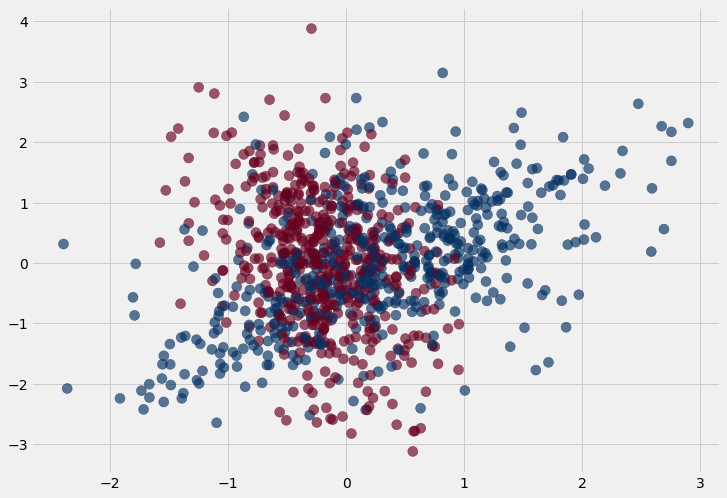

In [44]:
#Generate fake data that is 400 x 2.
data = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0, 
                    class_sep=.20, random_state = 34)
#Assign features to XX
X = data[0]
#Assign target variable to yy
y = data[1]

#Set size
plt.figure(figsize=(11, 8))

#Plot features and use to yy to color-encode
plt.scatter(X[:,0], X[:,1], c = y, s = 100, alpha=.65, cmap="RdBu");

In [45]:

#Train test split with 25% test size
X_train, X_test, y_train, y_test = train_test_split(X ,y,
                                                        test_size = .25,
                                                        random_state = 4)

#fit default model on the training set
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

#Evaluate model on training data
model.score(X_train, y_train)

1.0

Yay! Perfect model! 

Or is it????!!!

In [46]:
#Turn the y_test variable into list of colors
colors = list(map(lambda x: "red" if x == 1 else "blue", y_test.tolist()))

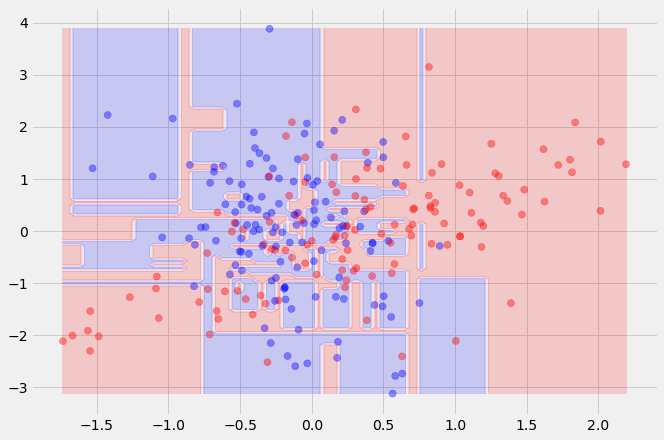

In [47]:
#Visualize the model and the testing data
plot_decision_boundary(model, X_test, colors);

How does that look to you? Where in the plot is the model overfit?

In [48]:
#Evaluate the model on the testing set
model.score(X_test, y_test)

0.66400000000000003

What does this mean? Why the huge gulf between the training and testing scores? What is the influence of max_depth?

Let's try this training/testing process again to see if we get different scores

<br><br>
Run this code several times and observe the changes in the testing score

In [49]:
#Different train/test split but with no random_state set
X_train, X_test, y_train, y_test = train_test_split(X ,y, test_size = .25)

#Fit model
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

training_score = model.score(X_train, y_train)

print ("The training score is {:.3f} percent".format(training_score*100))

testing_score = model.score(X_test, y_test)
print ("The testing score is {:.3f}".format(testing_score*100))

The training score is 100.000 percent
The testing score is 67.600


In [50]:
#Lets make this a for loop

#Intialize list that we'll use for our testing scores
testscorelist = []

#Iterate over range 10
for i in range(10):
    #Split data, fit model, test data, append testing score to testscorelist
    X_train, X_test, y_train, y_test = train_test_split(X ,y, test_size = .25)
    #Fit model
    model = DecisionTreeClassifier()
    model.fit(X_train, y_train)
    ts = model.score(X_test, y_test)
    testscorelist.append(ts)

testscorelist

[0.66000000000000003,
 0.69599999999999995,
 0.66400000000000003,
 0.67600000000000005,
 0.68400000000000005,
 0.65600000000000003,
 0.65200000000000002,
 0.65600000000000003,
 0.67200000000000004,
 0.64400000000000002]

## Cross Validation
<br><br>

"Cross-validation, sometimes called rotation estimation, is a model validation technique for assessing how the results of a statistical analysis will generalize to an independent data set." 

https://en.wikipedia.org/wiki/Cross-validation_(statistics)

<br><br>



<b>K-Fold Cross Validation</b>
![Image](https://i.stack.imgur.com/1fXzJ.png)

<br><br>
"[In K Fold cross validation](https://towardsdatascience.com/cross-validation-in-machine-learning-72924a69872f), the data is divided into k subsets. Now the holdout method is repeated k times, such that each time, one of the k subsets is used as the test set/ validation set and the other k-1 subsets are put together to form a training set. The error estimation is averaged over all k trials to get total effectiveness of our model. As can be seen, every data point gets to be in a validation set exactly once, and gets to be in a training set k-1 times. This significantly reduces bias as we are using most of the data for fitting, and also significantly reduces variance as most of the data is also being used in validation set. Interchanging the training and test sets also adds to the effectiveness of this method. As a general rule and empirical evidence, K = 5 or 10 is generally preferred, but nothing’s fixed and it can take any value."

Let's use cross_val_score function to perform KFold cross validation five times.

In [51]:
#Call cross_val_score, input empty DT model, X, y, set cv = 5 and scoring = accuracy
cv_scores = cross_val_score(DecisionTreeClassifier(), X, y, cv = 5, scoring = "accuracy")

#Call cv_scores
cv_scores

array([ 0.6318408 ,  0.66      ,  0.61      ,  0.65      ,  0.67839196])

We see theres a degree of variance in the output, which makes deriving the mean crucial.

In [52]:
#Whats the average score
cv_scores.mean()

0.64604655116377907

<b>Class exercise:</b>

Test to see the relationship between max_depth and the average cv_score. What happens when you increase or decrease max_depth. 

Whats you're done playing around with that, then make a line plot of depth values from 1 - 20 and the average cross validated score for each corresponding depth value.

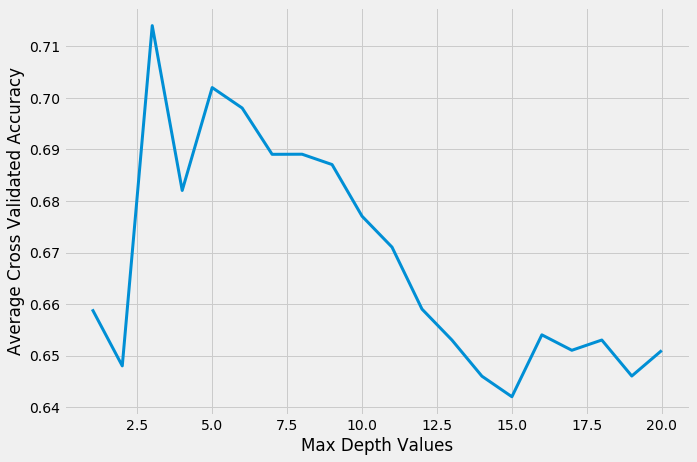

In [76]:
#Answer

depths = range(1, 21)

cv_scores = []

for i in depths:
    cv = cross_val_score(DecisionTreeClassifier(max_depth=i), X, y, cv =5, scoring="accuracy")
    cv_mean = cv.mean()
    cv_scores.append(cv_mean)
    
plt.plot(depths, cv_scores, linewidth = 3)
plt.xlabel("Max Depth Values")
plt.ylabel("Average Cross Validated Accuracy");

What is the best depth value?

The chart above is very similar to a validation curve, which we'll get more into later in the lesson.

Train a model with the best depth value and evaluate it on a test set

In [53]:
#Assign best depth value to depth
depth = 3

In [54]:
#Train and test
X_train, X_test, y_train, y_test = train_test_split(X ,y, 
                                                    test_size = .25,
                                                   random_state = 42)
#Fit model with best depth value
model = DecisionTreeClassifier(max_depth = depth, random_state= 42)
model.fit(X_train, y_train)

#Score model on test set
testscore = model.score(X_test, y_test)

print ("The test score is {:.3f} percent".format(testscore*100))

The test score is 73.600 percent


How does that compare to the null accuracy?

In [80]:
#Subtract null accuracy from testscore
null_acc = pd.value_counts(y_test, normalize=True).max()

testscore - null_acc

0.19599999999999995

Is this good or bad? How do you interpret this result?

The best depth is one that is not too small but not too large.

We need to find the depth that strikes the right balance between <b>bias</b> and <b>variance</b>

## Validation and Learning Curves

<b>Depicting bias vs variance with validation and learning curves</b>

Validation Curve:

![Lc](http://scott.fortmann-roe.com/docs/docs/BiasVariance/biasvariance.png)

<br><br>
Learning Curve:
![lc](https://chrisalbon.com/images/machine_learning_flashcards/Learning_Curve_print.png)
<br><br>
["Graph that compares the performance of a model on training and testing data over a varying number of training instances"](http://www.ritchieng.com/machinelearning-learning-curve/)

Before we go over how to make validation and learning curve plots in sklearn, let's import the titanic dataset and clean it.

In [92]:
#Load in dataset
path = "../../data/titanic.csv"

titanic = pd.read_csv(path)

titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<b>Data dictionary:</b>

PassengerID: A column added by Kaggle to identify each row and make submissions easier

Survived: Whether the passenger survived or not and the value we are predicting (0=No, 1=Yes)

Pclass:	The class of the ticket the passenger purchased (1=1st, 2=2nd, 3=3rd)

Sex: The passenger’s sex

Age: The passenger’s age in years

SibSp: The number of siblings or spouses the passenger had aboard the Titanic

Parch: The number of parents or children the passenger had aboard the Titanic

Ticket: The passenger’s ticket number

Fare: The fare the passenger paid

Cabin: The passenger’s cabin number

Embarked— The port where the passenger embarked (C=Cherbourg, Q=Queenstown, S=Southampton)

In [93]:
#Function to clean the data

def titanic_clean(df):
    df.columns = df.columns.str.lower()
    df.set_index("passengerid", inplace=True)
    df.age.fillna(df.age.median(), inplace = True)
    df.drop("cabin", axis =1, inplace= True)
    df.dropna(inplace=True)
    df.drop(["name", "ticket"], axis =1, inplace= True)
    gender_dict = {"male":0, "female":1}
    df["sex"] = df.sex.map(gender_dict)
    df_emb_dums = pd.get_dummies(df.embarked, prefix = "emb", drop_first=True)
    df.drop("embarked", axis =1 , inplace=True)
    df = pd.concat([df, df_emb_dums], axis =1 )
    return df

#pass data through function and reassign titanic

titanic = titanic_clean(titanic)

In [94]:
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,emb_Q,emb_S
passengerid,,,,,,,,,
1,0,3,0,22.0,1,0,7.2500,0,1
2,1,1,1,38.0,1,0,71.2833,0,0
3,1,3,1,26.0,0,0,7.9250,0,1
4,1,1,1,35.0,1,0,53.1000,0,1
5,0,3,0,35.0,0,0,8.0500,0,1


In [96]:
#First extract features and target variables

X = titanic.drop("survived", axis =1)
y = titanic.survived

In [97]:
#Null accuracy

y.value_counts(normalize=True)

0    0.617548
1    0.382452
Name: survived, dtype: float64

Our null accuracy is 61.75%. That means we have to create a model that classifies the data at a better rate than 61.75%.

If we didn't build a model and just said everyone died, then we'd be 61.75% without even going through the trouble of building a model.

### Validation Curve

Code adapted from [www.chrisalbon.com](www.chrisalbon.com)

In [55]:
# Create range of values for parameter
depth_range = np.arange(1, 25)

# Calculate accuracy on training and test set using range of parameter values
train_scores, test_scores = validation_curve(DecisionTreeClassifier(), 
                                             X, 
                                             y, 
                                             param_name="max_depth", 
                                             param_range=depth_range,
                                             cv=3, 
                                             scoring="accuracy")

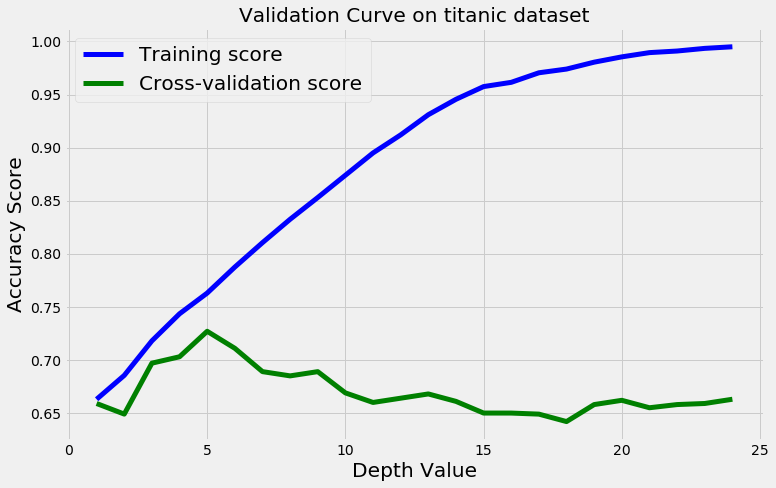

In [56]:
# Calculate mean for training set scores
train_mean = np.mean(train_scores, axis=1)

# Calculate mean for test set scores
test_mean = np.mean(test_scores, axis=1)


#Set size
plt.figure(figsize=(11, 7))

# Plot mean accuracy scores for training and test sets
plt.plot(depth_range, train_mean, label="Training score", color="blue", linewidth = 5)
plt.plot(depth_range, test_mean, label="Cross-validation score", color="green", linewidth = 5)



# Create plot

plt.title("Validation Curve on titanic dataset", fontsize = "x-large")
plt.xlabel("Depth Value", fontsize = "x-large")
plt.ylabel("Accuracy Score",  fontsize = "x-large")
plt.tight_layout()
plt.legend(loc="best", fontsize = "x-large")

plt.show()

What does this graph mean? 

### Learning curve

In [57]:
#Assign best depth value to depth

depth = 3

In [58]:
#Create values for train_sizes, train_scores, and test_scores
train_sizes, train_scores, test_scores = learning_curve(DecisionTreeClassifier(max_depth = depth), 
                                                        X, 
                                                        y,
                                                        # Number of folds in cross-validation
                                                        cv=5,
                                                        # Evaluation metric
                                                        scoring='accuracy',
                                                        # 50 different sizes of the training set
                                                        train_sizes=np.linspace(0.01, 1.0, 50))

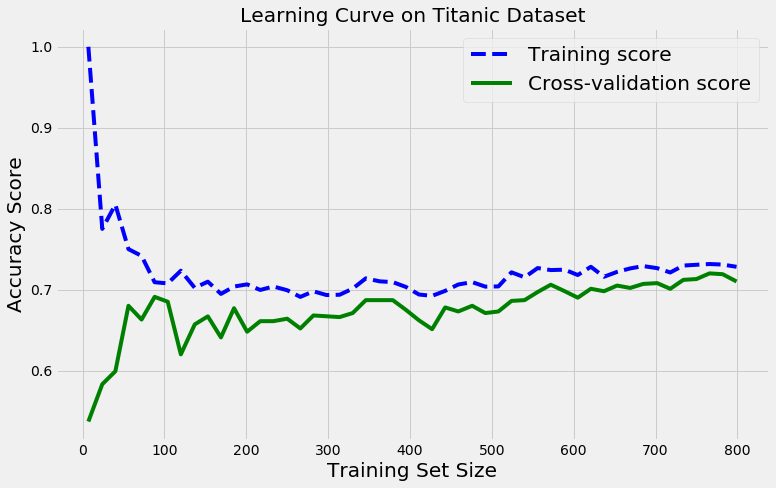

In [60]:
# Create means of training set scores
train_mean = np.mean(train_scores, axis=1)

# Create means of test set scores
test_mean = np.mean(test_scores, axis=1)

#Set size
plt.figure(figsize=(11, 7))

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="blue",  label="Training score")
plt.plot(train_sizes, test_mean, color="green", label="Cross-validation score")


# Create plot

plt.title("Learning Curve on Titanic Dataset", fontsize = "x-large")
plt.xlabel("Training Set Size", fontsize = "x-large")
plt.ylabel("Accuracy Score",  fontsize = "x-large")
plt.tight_layout()
plt.legend(loc="best", fontsize = "x-large")

plt.show()

In [65]:
#can help you decide if you need more data
# learning curve - plotting train set size vs model performance 
# validation curve - depth value vs model performance (
# depth is complexity of model (too many questions classify incorrectly)

What are your initial observations of this graph? What does it say about your model and your data?

Bonus!!
<br><br>
Let's see the most important features and visualize the decision tree

In [61]:
#Fit DT model on X and y with max_depth 4

dt = DecisionTreeClassifier(max_depth=4)
dt.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [62]:
#Call .feature_importances
dt.feature_importances_

array([ 0.81003986,  0.18996014])

In [63]:
#Lets put that in a dataframe
fi = pd.DataFrame(list(zip(X.columns, dt.feature_importances_)), columns=["feature", "importance"])
fi

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [ ]:
#Sort it

fi.sort_values(by = "importance", ascending=False)

In [64]:
#Export the decision tree graph viz object. We have to export and the re-import it
export_graphviz(dt, out_file='titanic.dot', 
                    feature_names=X.columns, 
                    class_names=["dead", "alive"])
with open("titanic.dot") as f: 
        dot_graph = f.read()
graphviz.Source(dot_graph)

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

### Resources:

Bias vs variance:

https://ml.berkeley.edu/blog/2017/07/13/tutorial-4/

https://machinelearningmastery.com/gentle-introduction-to-the-bias-variance-trade-off-in-machine-learning/

http://www.machinelearningtutorial.net/2017/01/26/the-bias-variance-tradeoff/

https://followthedata.wordpress.com/2012/06/02/practical-advice-for-machine-learning-bias-variance/


<br><br>
Cross validation:

https://stats.stackexchange.com/questions/1826/cross-validation-in-plain-english

https://www.analyticsvidhya.com/blog/2015/11/improve-model-performance-cross-validation-in-python-r/

https://www.openml.org/a/estimation-procedures/1

<br><br>
Learning and validation curves:

->->**https://www.dataquest.io/blog/learning-curves-machine-learning/**

https://jakevdp.github.io/PythonDataScienceHandbook/05.03-hyperparameters-and-model-validation.html

<br><br>
Titanic dataset projects:

https://www.kaggle.com/maielld1/titanic-dataquest-tutorial

https://github.com/agconti/kaggle-titanic

https://ahmedbesbes.com/how-to-score-08134-in-titanic-kaggle-challenge.html

### Class work 

For the rest of class, work on improving your model as much as possible. 

- See what happens when you drop different features
- Try different combinations of them
- Try making pclass into a dummy variable instead of a continuous one
- Make predictions of "fake passengers". Input a bunch of features to see what happens.
- You can also try these techniques on other datasets as well.

You're also welcome to spend the rest of the class checking out the resources I provided above.

In [66]:
# sort it 
# fi.sort_values(by = "importance_score", ascending=False)

NameError: name 'fi' is not defined